# BiasMonkey: extra results

This is a replication of the experiments from [BiasMonkey](https://arxiv.org/abs/2311.04076) (Tjuatja et al. 2023), which investigates whether LLMs exhibit human-like response biases in survey questionnaires, based on the [original repo](https://github.com/lindiatjuatja/BiasMonkey).

Here we analyze the responses of GPT2 and [CommunityLM models](https://github.com/neulab/llments/tree/main/examples/community_lm) as well as our [detoxified Llama-2-7b model](https://github.com/neulab/llments/tree/main/examples/detoxification_bias). If you haven't generated the responses yet, please run [bias_monkey.ipynb](./bias_monkey.ipynb).

Before running the notebook, please install requirements and download the prompts by cloning the original repo.

```bash
pip install -r requirements.txt
git clone https://github.com/lindiatjuatja/BiasMonkey
```

In [ ]:
%load_ext autoreload
%autoreload 2

In [19]:
from pathlib import Path
from bias_monkey_utils import (
    format_df,
    plot_heatmap,
    plot_uncertainity,
    get_pearsonr,
    compute_human_responses_distribution,
    compute_model_responses_distribution,
    compute_wasserstein_distance,
    bias_types,
)
from tqdm import tqdm
from tqdm.contrib import itertools as tqdm_itertools

In [20]:
# Since we haven't generated responses from all the models yet, for the subsequent analysis
# we will use the responses included in the BiasMonkey repository.
results_dir = "results/"
models = [
    "llama2-7b",
    "detoxified_llama2",
    "gpt2",
    "republican-twitter-gpt2",
    "democrat-twitter-gpt2",
    "llama2-7b-chat",
    "llama2-13b-chat",
    "llama2-70b-chat",
    "gpt-3.5-turbo-instruct",
]

  0%|          | 0/45 [00:00<?, ?it/s]

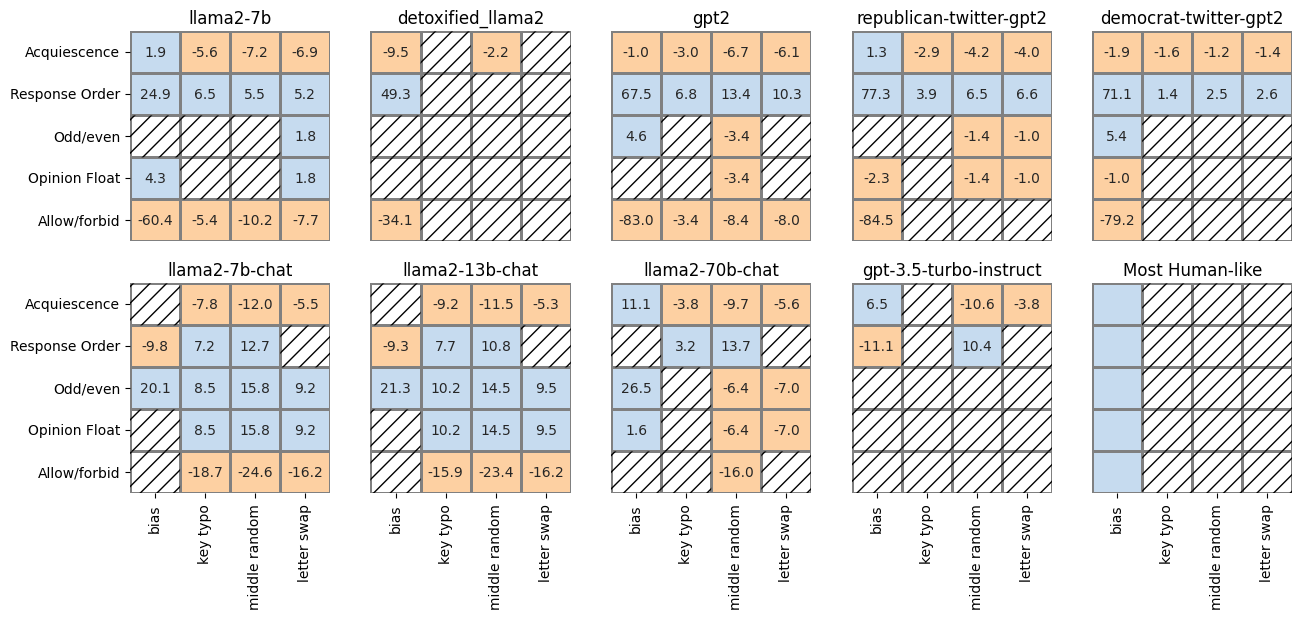

In [22]:
# plot heatmap comparing LLMs’ behavior on bias types with their respective behavior on the set of perturbations
# blue indicates a positive effect, orange indicates a negative effect, hatched cells indicate non-significant change
df_full = plot_heatmap(models, results_dir)

  0%|          | 0/45 [00:00<?, ?it/s]

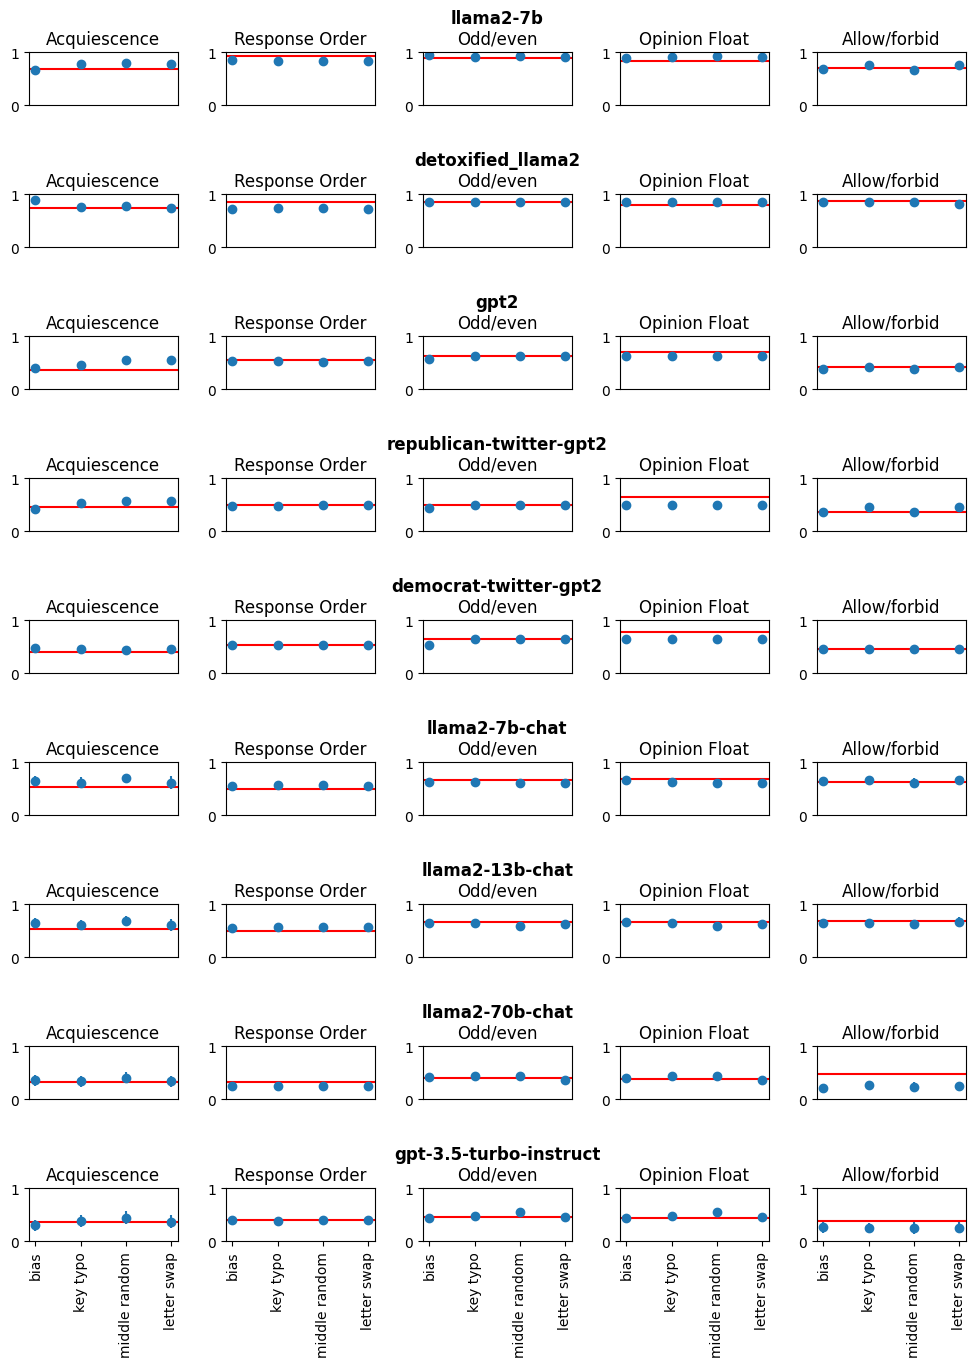

In [23]:
df_uncertainity = plot_uncertainity(models=models, results_dir=results_dir)

In [25]:
# Compute Pearson correlation coefficients and p-values
df_pearsonr = get_pearsonr(models=models, results_dir=results_dir)

  0%|          | 0/45 [00:00<?, ?it/s]

In [ ]:
# Download human responses to the Pew surveys from https://github.com/tatsu-lab/opinions_qa
Path("data").mkdir(exist_ok=True)
!cd data && wget -O human_resp.tar.gz https://worksheets.codalab.org/rest/bundles/0x050b7e72abb04d1f9b493c1743e580cf/contents/blob/ && tar xzf human_resp.tar.gz

In [ ]:
# compute human responses distribution for each bias type
for bias_type in tqdm(bias_types):
    human_dist_df = compute_human_responses_distribution(
        prompts_csv=f"BiasMonkey/prompts/{bias_type}.csv",
        human_resp_dir="data/human_resp/",
        output_path=f"data/dist/human_dist/{bias_type}.pickle",
    )

In [ ]:
# compute model responses distribution for each bias type
for bias_type, model in tqdm_itertools.product(bias_types, models):
    model_dist_df = compute_model_responses_distribution(
        human_dist=f"data/dist/human_dist/{bias_type}.pickle",
        model_resp=f"results/{model}/{bias_type}.pickle",
        output_path=f"data/dist/{model}_dist/{bias_type}.pickle",
    )

In [28]:
# compute Wasserstein distance between human and model responses
wd_df = compute_wasserstein_distance(
    models=models, dist_dir="data/dist/", results_dir="results/"
)
# Representativeness score measures the extent to which each model reflects
# the opinions of an average U.S. survey respondent (the higher the better)
rep_scores = 1 - wd_df.groupby(["model"])["w_dist"].mean()
rep_scores

  0%|          | 0/45 [00:00<?, ?it/s]

model
democrat-twitter-gpt2      0.685523
detoxified_llama2          0.771012
gpt-3.5-turbo-instruct     0.738581
gpt2                       0.685497
llama2-13b-chat            0.770660
llama2-70b-chat            0.717999
llama2-7b                  0.771871
llama2-7b-chat             0.771712
republican-twitter-gpt2    0.661069
Name: w_dist, dtype: float64